In [1]:
import pandas as pd
import sqlite3

In [2]:
connection = sqlite3.connect("../data/checking-logs.sqlite")

In [3]:
query = """
WITH weekday_commits AS (
    SELECT
        DATE(timestamp) AS date,
        strftime('%H', timestamp) AS hour,
        COUNT(*) AS commits
    FROM checker
    WHERE 
        uid LIKE 'user_%'
        AND strftime('%w', timestamp) IN ('1', '2', '3', '4', '5')
    GROUP BY DATE(timestamp), strftime('%H', timestamp)
),
weekend_commits AS (
    SELECT
        DATE(timestamp) AS date,
        strftime('%H', timestamp) AS hour,
        COUNT(*) AS commits
    FROM checker
    WHERE 
        uid LIKE 'user_%'
        AND strftime('%w', timestamp) IN ('6', '0')
    GROUP BY DATE(timestamp), strftime('%H', timestamp)
)
SELECT 
    'working_day' AS weekday_type,
    hour,
    AVG(commits) AS avg_commits
FROM
    weekday_commits
WHERE
    commits > 0
GROUP BY
    hour
UNION ALL
SELECT
    'weekend' AS weekday_type,
    hour,
    AVG(commits) AS avg_commits
FROM
    weekend_commits
WHERE
    commits > 0
GROUP BY
    hour;
"""
df = pd.io.sql.read_sql(query, connection)
df.head()


,weekday_type,hour,avg_commits
0,working_day,00,3.000000
1,working_day,03,2.000000
2,working_day,05,7.500000
3,working_day,06,1.500000
4,working_day,07,5.166667


In [4]:
df_pivot = df.pivot(index='hour', columns='weekday_type', values='avg_commits').fillna(0)

In [5]:
df_pivot

weekday_type,weekend,working_day
hour,,
00,2.000000,3.000000
01,6.000000,0.000000
03,1.000000,2.000000
05,2.000000,7.500000
06,0.000000,1.500000
07,4.000000,5.166667
08,7.000000,3.700000
09,3.666667,6.000000
10,7.000000,13.200000


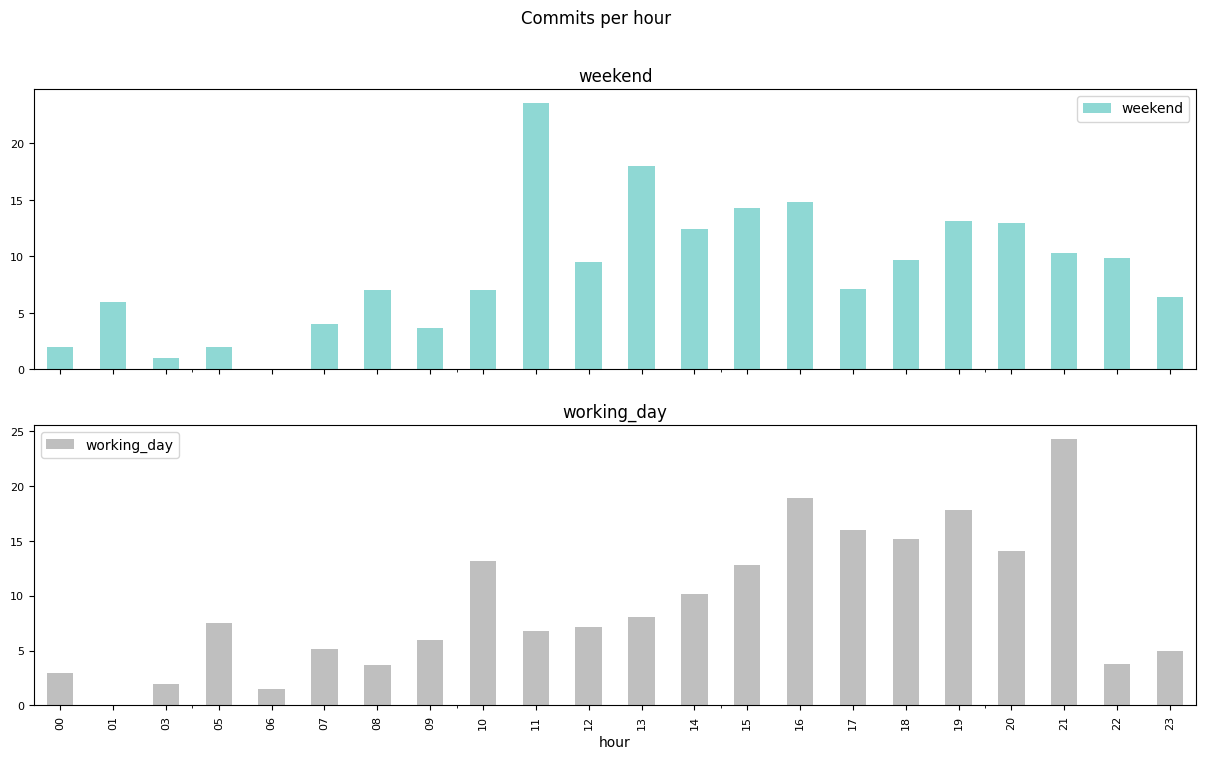

In [6]:
ax = df_pivot.plot.bar(
    subplots=True,
    figsize=(15,8),
    fontsize=8,
    color=['lightseagreen', 'grey'],
    alpha=0.5,
    title='Commits per hour'
)

## Is the dynamic different on working days and weekends?

It is! The hour when the number of commits is the largest during working days is 21 while during weekends it is 11.